In [1]:
from io import StringIO
import requests
import pandas as pd

## Register with PVOutput.org
As well as an API key, uou *need* a SystemId to use the API.  (If you don't include a SystemId, then you'll get a "401 Unauthorized" response).  If you don't have a PV system, click the "energy consumption only" box.

## Good systems
Good system: https://pvoutput.org/intraday.jsp?id=68872&sid=61190

## API docs
The following HTTP Headers need to be set to authenticate the service request.

* X-Pvoutput-Apikey
* X-Pvoutput-SystemId

### Useful sections in API docs
* [API Search](https://pvoutput.org/help.html#api-search)
* [Get Status](https://pvoutput.org/help.html#api-getstatus) - used for getting live and historical PV power output (and other data)




In [135]:
SECONDS_PER_DAY = 60 * 60 * 24

class BadStatusCode(Exception):
    pass


def pv_output_api_query(service, api_params):
    """
    Args:
        service: string, e.g. 'search', 'getstatus'
    """
    
    headers = {
        'X-Pvoutput-Apikey': '3f784ff6cfa27c44436f88da0c429b410687ad14',
        'X-Pvoutput-SystemId': '68732'}
    
    api_base_url = 'https://pvoutput.org/service/r2/{}.jsp'.format(service)
    api_params_str = '&'.join(['{}={}'.format(key, value) for key, value in api_params.items()])
    api_url = '{}?{}'.format(api_base_url, api_params_str)
    response = requests.get(api_url, headers=headers)
    
    content = response.content.decode('utf-8').strip()
    if response.status_code == 200:
        return content
    else:
        raise BadStatusCode('Bad status code returned: {}, {}'.format(response.status_code, content))

## Search for PV systems

In [81]:
def pv_system_search(query, lat_lon):
    """
    Args:
        query: string, see https://pvoutput.org/help.html#search
            e.g. '5km'.  Max search radius = 25km
        lat_lon: string, e.g. '52.0668589,-1.3484038'
        
    Returns:
        pd.DataFrame.  Beware the maximum number of results returned by PVOutput.org is 30.
    """
    
    pv_systems_text = pv_output_api_query(
        service='search',
        api_params={
            'q': query,
            'll': lat_lon,
            'country': 1  # country flag, whether or not to return country with the postcode
        })
    
    pv_systems = pd.read_csv(
        StringIO(pv_systems_text),
        names=[
            'system_name',
            'system_size_watts',
            'postcode',
            'orientation',
            'num_outputs',
            'last_output',
            'system_id',
            'panel',
            'inverter',
            'distance_km',
            'latitude',
            'longitude'],
        index_col='system_id')

    return pv_systems

In [82]:
pv_systems = pv_system_search(query='5km', lat_lon='52.0668589,-1.3484038')

,system_name,system_size_watts,postcode,orientation,num_outputs,last_output,panel,inverter,distance_km,latitude,longitude
system_id,,,,,,,,,,,
68309,Thorn House,3960,United Kingdom OX16,SE,0,No Outputs,Evolution Ultra PLM-330MB-66,Growatt,1.0,52.06,-1.34
61190,Banbury OX16,5600,United Kingdom OX16,S,332,Today,SunPower,SolarEdge 5K HD,1.0,52.06,-1.34
7191,Banbury Power Plant 2,3920,United Kingdom OX16,SE,1,380 weeks ago,Suntech STP245S,SMA SB3800V,1.0,52.06,-1.34
62751,Banbury PW2,5600,United Kingdom OX16,S,83,25 weeks ago,Sunpower,Energy Monitor,1.0,52.06,-1.34
38924,CotonMacy Solar,3900,United Kingdom OX16,S,1461,Today,LG LG300 N1C-B3 LG,Enphase m250,1.0,52.06,-1.34
5390,homedazza,1920,United Kingdom OX16,SW,0,No Outputs,suntech,sunnyboy,1.0,52.06,-1.34
23236,Tedsolar,3000,United Kingdom OX16,SE,691,205 weeks ago,Renesolar,Samil SR3300tl,1.0,52.06,-1.34
40099,100061702,195,United Kingdom OX17,S,0,No Outputs,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28
40100,100061786,3900,United Kingdom OX17,S,62,183 weeks ago,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28


In [83]:
good_pv_systems = pv_systems.query('num_outputs > 50')
good_pv_systems

,system_name,system_size_watts,postcode,orientation,num_outputs,last_output,panel,inverter,distance_km,latitude,longitude
system_id,,,,,,,,,,,
61190,Banbury OX16,5600,United Kingdom OX16,S,332,Today,SunPower,SolarEdge 5K HD,1.0,52.06,-1.34
62751,Banbury PW2,5600,United Kingdom OX16,S,83,25 weeks ago,Sunpower,Energy Monitor,1.0,52.06,-1.34
38924,CotonMacy Solar,3900,United Kingdom OX16,S,1461,Today,LG LG300 N1C-B3 LG,Enphase m250,1.0,52.06,-1.34
23236,Tedsolar,3000,United Kingdom OX16,SE,691,205 weeks ago,Renesolar,Samil SR3300tl,1.0,52.06,-1.34
40100,100061786,3900,United Kingdom OX17,S,62,183 weeks ago,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28
36566,CartwrightRoad,3900,United Kingdom OX17,S,3012,Today,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28


## Get system status (power generation)

In [114]:
def get_pv_system_status(pv_system_id, date):
    """
    Args:
        pv_system_id: int
        date: str, YYYYMMDD
    """
    pv_system_status_text = pv_output_api_query(
        service='getstatus',
        api_params={
            'd': date, # date, YYYYMMDD
            'h': 1,  # History; we want historical data
            'limit': SECONDS_PER_DAY,  # API docs say limit is 288 (number of 5-min periods per day),
                                       # but let's try to get number of secs per day just in case 
                                       # some PV systems have 1-second updates.
            'ext': 0, # extended data; we don't want extended data because it's not clear how to parse it.
            'sid1': pv_system_id # SystemID
        })
    
    pv_system_status = pd.read_csv(
        StringIO(pv_system_status_text),
        lineterminator=';',
        names=[
            'date',
            'time',
            'energy_generation_watt_hours',
            'energy_efficiency_kWh_per_kW',
            'inst_power_watt',
            'average_power_watt',
            'normalised_output',
            'energy_consumption_watt_hours',
            'power_consumption_watts',
            'temperature_celsius',
            'voltage'
        ],
        parse_dates={'datetime': ['date', 'time']},
        index_col=['datetime']
    )
    
    return pv_system_status

In [120]:
pv_system_id = 38924
pv_system_status = get_pv_system_status(pv_system_id, date='20190715')
pv_system_status.describe()

,energy_generation_watt_hours,energy_efficiency_kWh_per_kW,inst_power_watt,average_power_watt,normalised_output,energy_consumption_watt_hours,power_consumption_watts,temperature_celsius,voltage
count,196.000000,196.000000,196.000000,195.000000,195.000000,0.0,0.0,0.0,0.0
mean,6320.622449,1.620684,900.882653,905.476923,0.232195,NaN,NaN,NaN,NaN
std,5550.282705,1.423158,709.945756,709.131568,0.181844,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,847.000000,0.217250,229.250000,240.000000,0.062000,NaN,NaN,NaN,NaN
50%,4860.500000,1.246500,852.000000,864.000000,0.222000,NaN,NaN,NaN,NaN
75%,12096.500000,3.101750,1373.500000,1374.000000,0.352500,NaN,NaN,NaN,NaN
max,14714.000000,3.773000,2662.000000,2664.000000,0.683000,NaN,NaN,NaN,NaN


In [121]:
pv_system_status.head()

,energy_generation_watt_hours,energy_efficiency_kWh_per_kW,inst_power_watt,average_power_watt,normalised_output,energy_consumption_watt_hours,power_consumption_watts,temperature_celsius,voltage
datetime,,,,,,,,,
2019-07-15 21:20:00,14714,3.773,0,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:15:00,14714,3.773,0,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:10:00,14714,3.773,4,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:05:00,14714,3.773,12,12.0,0.003,NaN,NaN,NaN,NaN
2019-07-15 21:00:00,14713,3.773,12,12.0,0.003,NaN,NaN,NaN,NaN


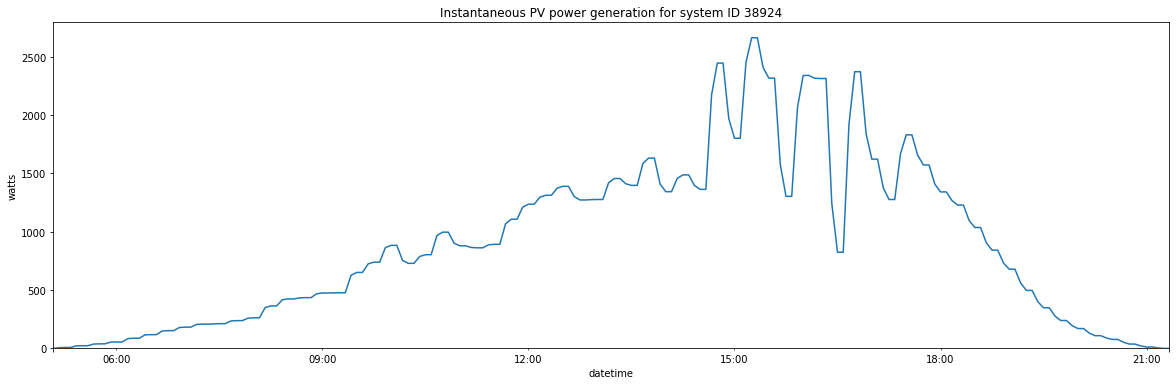

In [132]:
ax = pv_system_status['inst_power_watt'].plot(figsize=(20, 6))
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_ylabel('watts')
ax.set_title('Instantaneous PV power generation for system ID {}'.format(pv_system_id));

## Get system metadata

In [186]:
def get_pv_metadata(pv_system_id):
    """
    Args:
        pv_system_id: int
    """
    pv_metadata_text = pv_output_api_query(
        service='getsystem',
        api_params={
            'array2': 1,  # provide data about secondary array, if present
            'tariffs': 0,
            'teams': 0,
            'est': 0,
            'donations': 0,
            'sid1': pv_system_id, # SystemID
            'ext': 0, # extended data
        })
    
    pv_metadata = pd.read_csv(
        StringIO(pv_metadata_text),
        lineterminator=';',
        names=[
            'system_name',
            'system_size_watts',
            'postcode',
            'number_of_panels',
            'panel_power_watts',
            'panel_brand',
            'num_inverters',
            'inverter_power_watts',
            'inverter_brand',
            'orientation',
            'array_tilt_degrees',
            'shade',
            'install_date',
            'latitude',
            'longitude',
            'status_interval_minutes',
            'number_of_panels_secondary',
            'panel_power_watts_secondary',
            'orientation_secondary',
            'array_tilt_degrees_secondary'
        ],
        parse_dates=['install_date'],
        nrows=1
    ).squeeze()
    pv_metadata['system_id'] = pv_system_id
    pv_metadata.name = pv_system_id
    
    return pv_metadata

In [187]:
pv_metadata = get_pv_metadata(pv_system_id)

In [188]:
pv_metadata

system_name                         CotonMacy Solar
system_size_watts                              3900
postcode                                       OX16
number_of_panels                                 13
panel_power_watts                               300
panel_brand                      LG LG300 N1C-B3 LG
num_inverters                                    13
inverter_power_watts                            250
inverter_brand                         Enphase m250
orientation                                       S
array_tilt_degrees                                1
shade                                            No
install_date                    2015-06-27 00:00:00
latitude                                      52.06
longitude                                     -1.34
status_interval_minutes                           5
number_of_panels_secondary                        0
panel_power_watts_secondary                       0
orientation_secondary                           NaN
array_tilt_d

# How many API requests?

In [190]:
api_requests_per_system_per_year = 365
number_of_pv_systems = 2500

api_requests = number_of_pv_systems * api_requests_per_system_per_year
api_requests

912500

In [195]:
requests_per_hour = 3600  # 60 for donation mode; 900 if we pay $300; 3600 if we pay $900
request_hours = api_requests / requests_per_hour
request_hours

253.47222222222223

In [196]:
request_hours / 24

10.561342592592593

Next steps:

* Use search to get all systems in UK - take a look at commercial service
* Find systems with more than ~50 data points, and update freq of hourly or better.

* Load map of Britain
* Create grid of 35km spacing throughout Britain
* Mask this grid with map of Britain